## Imports and data

In [244]:
import pandas as pd 
import numpy as np 
import datetime
import matplotlib.pyplot as plt 
import seaborn as sns

In [245]:
#loading data
reviews = pd.read_csv('../fobokiller/data/scrapping_cleaned.csv',index_col = 0)
info = pd.read_csv('../fobokiller/data/final_resto_list.csv', index_col =0)

#merging dataframes
df = reviews.merge(info,on='alias',how='left')

#drop null
df.dropna(inplace=True)

#date
df['date'] = pd.to_datetime(df['date'])

#drop useless columns and rearrange
df.drop(columns=['review','url','address'],inplace=True)
df = df.reindex(columns=['alias','name','categories','date','zip_code','latitude',
                    'longitude','price','rating','review_clean','rate'])
df.rename(columns={
    'price':'price_range',
    'rating':'place_rate',
    'rate':'review_rate'
},inplace=True)

In [246]:
print(df.shape),
df.head()

(45557, 11)


,alias,name,categories,date,zip_code,latitude,longitude,price_range,place_rate,review_clean,review_rate
0,le-sud-paris,Le Sud,french,2018-11-20,75017.0,48.878948,2.284763,3.0,3.5,traditional parisian cooking style restaurant ...,5
1,le-sud-paris,Le Sud,french,2021-07-04,75017.0,48.878948,2.284763,3.0,3.5,im sure happening restaurant excited dine serv...,2
2,le-sud-paris,Le Sud,french,2018-06-20,75017.0,48.878948,2.284763,3.0,3.5,ambience enticing end day definitely directed ...,3
3,le-sud-paris,Le Sud,french,2015-09-28,75017.0,48.878948,2.284763,3.0,3.5,ambience star opinion expensive tourist trap m...,3
4,le-sud-paris,Le Sud,french,2019-08-08,75017.0,48.878948,2.284763,3.0,3.5,worst restaurant ever servers help us food bla...,1


## Data preprocessing

In [247]:
#create one column per category
df[['category_1', 'category_2', 'category_3','category_4','category_5']] = df['categories'].str.split(', ', expand=True)

#check how many null per n_category (i.e. no category provided sor this level)
df.isnull().sum()

alias               0
name                0
categories          0
date                0
zip_code            0
latitude            0
longitude           0
price_range         0
place_rate          0
review_clean        0
review_rate         0
category_1          0
category_2      22370
category_3      37167
category_4      45446
category_5      45536
dtype: int64

In [248]:
#delete categories 3 4 5 as well as original cat
df.drop(columns=['category_3','category_4','category_5','categories'],inplace=True)
df.head()

,alias,name,date,zip_code,latitude,longitude,price_range,place_rate,review_clean,review_rate,category_1,category_2
0,le-sud-paris,Le Sud,2018-11-20,75017.0,48.878948,2.284763,3.0,3.5,traditional parisian cooking style restaurant ...,5,french,None
1,le-sud-paris,Le Sud,2021-07-04,75017.0,48.878948,2.284763,3.0,3.5,im sure happening restaurant excited dine serv...,2,french,None
2,le-sud-paris,Le Sud,2018-06-20,75017.0,48.878948,2.284763,3.0,3.5,ambience enticing end day definitely directed ...,3,french,None
3,le-sud-paris,Le Sud,2015-09-28,75017.0,48.878948,2.284763,3.0,3.5,ambience star opinion expensive tourist trap m...,3,french,None
4,le-sud-paris,Le Sud,2019-08-08,75017.0,48.878948,2.284763,3.0,3.5,worst restaurant ever servers help us food bla...,1,french,None


In [249]:
df[df['date']>datetime.datetime(2015,1,1)].shape

(34453, 12)

## Data distribution

### Restaurants distribution

In [250]:
#create df rest
rest = df[['alias','name','zip_code','price_range','place_rate','review_rate',
           'category_1','category_2','review_clean']]\
    .groupby(['alias','name'])\
    .agg({'zip_code':np.mean,
          'price_range':np.mean,
          'place_rate':np.mean,
          'review_rate':np.mean,
         'category_1':'first',
          'category_2':'first',
         'review_clean':'count'}).reset_index()
rest.rename(columns={'review_clean':'review_count'},inplace=True)
rest.head()

,alias,name,zip_code,price_range,place_rate,review_rate,category_1,category_2,review_count
0,14-paradis-paris,14 Paradis,75010.0,3.0,4.0,3.500000,french,None,2
1,142-crêperie-contemporaine-paris-3,142 Crêperie Contemporaine,75015.0,2.0,4.5,4.560000,creperies,None,75
2,3-pièces-cuisine-paris-2,3 Pièces Cuisine,75017.0,2.0,3.5,4.500000,wine_bars,bistros,4
3,42-degrés-paris,42 Degrés,75009.0,3.0,4.0,4.200000,vegan,raw_food,5
4,58-tour-eiffel-paris,58 Tour Eiffel,75007.0,4.0,3.5,3.484536,french,None,291


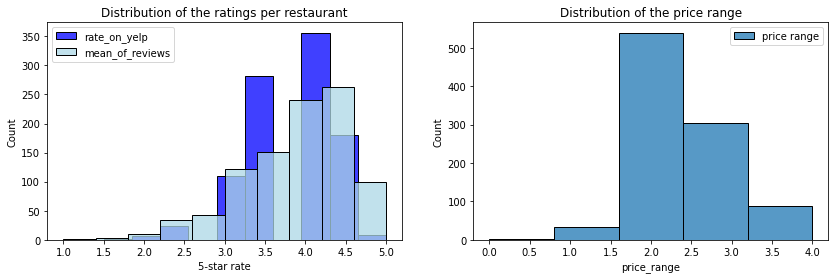

In [251]:
#Distribution of the ratings per restaurant'

fig,axs = plt.subplots(1,2,figsize=(14,4))

sns.histplot(x=rest['place_rate'],label='rate_on_yelp',ax=axs.flat[0],bins=10,color='blue')
sns.histplot(x=rest['review_rate'],label='mean_of_reviews',ax=axs.flat[0],bins=10,color='lightblue');
axs.flat[0].set_title('Distribution of the ratings per restaurant')
axs.flat[0].set_xlabel('5-star rate')
axs.flat[0].legend();

sns.histplot(x=rest['price_range'],label='price range',ax=axs.flat[1],bins=5);
axs.flat[1].set_title('Distribution of the price range')
axs.flat[1].legend();

### Categories distribution

In [341]:
#categories1 df
categories = rest.groupby('category_1').agg({'name':'count','review_count':'sum'}).reset_index()
#filter out categories with less than 10 restaurants
categories = categories[categories['name']>10]

#categories 2 df
categories2 = rest.groupby('category_2').agg({'name':'count','review_count':'sum'}).reset_index()
#filter out categories2 with less than 10 restaurants
categories2 = categories2[categories2['name']>10]

(18, 3)

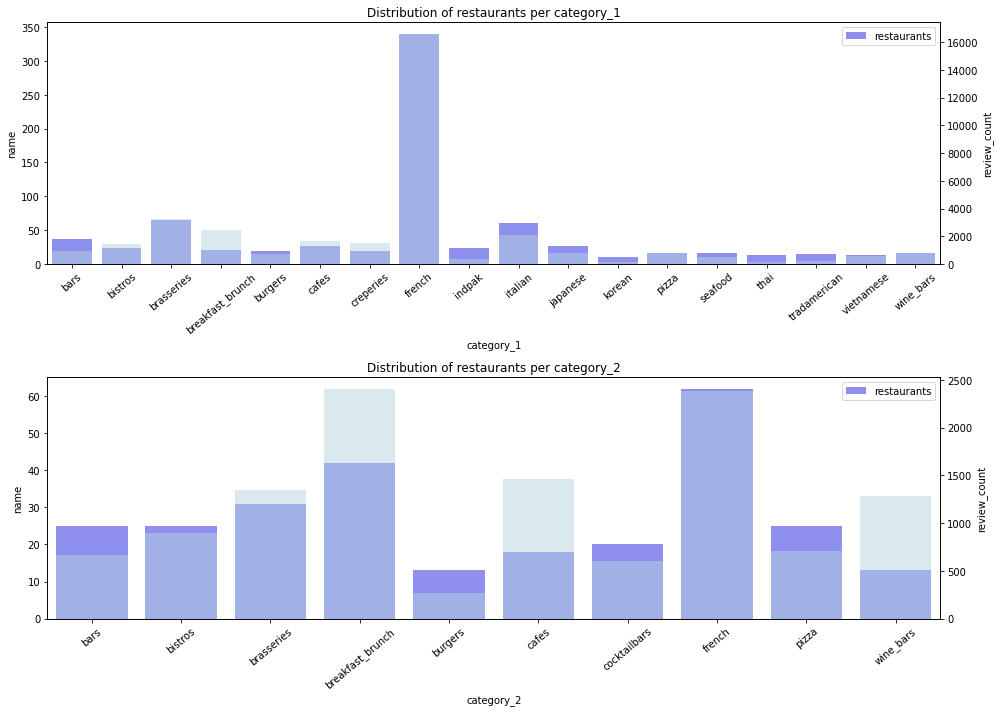

In [333]:
fig,axs = plt.subplots(2,1,figsize=(14,10))


sns.barplot(x=categories['category_1'],y=categories['name'],color='blue',
            ax=axs[0],alpha=0.5,label='restaurants')

ax2=axs[0].twinx()
sns.barplot(x=categories['category_1'],y=categories['review_count'],color='lightblue',ax=ax2,alpha=0.5)

axs[0].set_xticklabels(labels=categories['category_1'],rotation=40);
axs[0].set_title('Distribution of restaurants per category_1');
axs[0].legend();

sns.barplot(x=categories2['category_2'],y=categories2['name'],color='blue',
            ax=axs[1],alpha=0.5,label='restaurants')

ax3=axs[1].twinx()
sns.barplot(x=categories2['category_2'],y=categories2['review_count'],color='lightblue',
            ax=ax3,alpha=0.5,label='reviews')

axs[1].set_xticklabels(labels=categories2['category_2'],rotation=40);
axs[1].set_title('Distribution of restaurants per category_2');
axs[1].legend();
fig.tight_layout();

### Time 


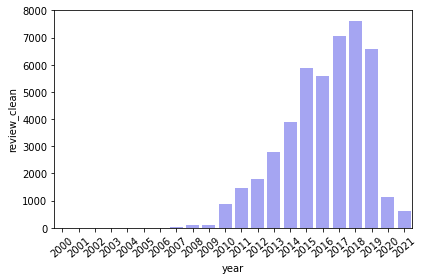

In [321]:
df['year']=df['date'].apply(lambda x:x.year)
years_df = df[['year','review_clean']].groupby('year').count().reset_index()
#years_df.plot(kind='bar');
ax=sns.barplot(x=years_df['year'],y=years_df['review_clean'],color='blue',alpha=.4)
ax.set_xticklabels(labels=years_df['year'],rotation=40);
plt.tight_layout()

## Wordclouds per category

In [324]:
#create the two lists of categories 
cat1_list=list(categories['category_1'])
cat2_list=list(categories2['category_2'])

### Word cloud for good reviews (>=4)

In [401]:
#aggregate all the reviews per categories_1
categories_reviews = df[df['review_rate']>3].groupby('category_1').agg({'name':'count',
                                                   'review_clean':'count',
                                                    'review_clean':' '.join})
categories_reviews.rename(columns={'name':'review_count'},inplace=True)

categories_reviews2 = df[df['review_rate']>3].groupby('category_2').agg({'name':'count',
                                                   'review_clean':'sum',
                                                    'review_clean':' '.join})
categories_reviews2.rename(columns={'name':'review_count'},inplace=True)

In [392]:
from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=50, max_words=30, background_color="white",).generate(categories_reviews.loc[5,'review_clean'])

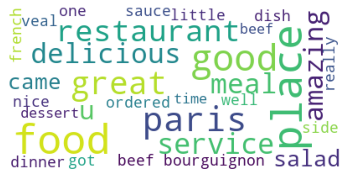

In [393]:

plt.imshow(wordcloud)
plt.axis('off');

In [397]:
categories_reviews.loc[cat1_list[1],'review_clean']

'fantastique dîner une très belle carte des vins avec de bonnes recommandations dun personnel qui sait ce quil dans lassiette et le verre les portions sont généreuses mais cest surtout créatif et délicieux les ris de veau étaient superbes très belle côte de cochon noir de bigorre cuite à la perfection hands favorite restaurant paris bit way staying central location however well worth trip restaurant one thing note menus english problem however verbally translate menu parents starters inventive menu changes seasonally pork belly beef bearnaise favorite meals matter order though go wrong lastly inexpensive meal shocked reasonable bill caliber service quality meal beaten path good aware red mullet menu comes whole fishhead good though lamb awesome restaurant pure perfection im rarely ever th never make dining destination weekend found quiet residential part city part wedding anniversary staycation coretta romantic dinner spot even though warned might seated one bar stool tables arrived gi

In [409]:
#list of stopwords related to food
stopwords=['food','restaurant','good','place','paris']

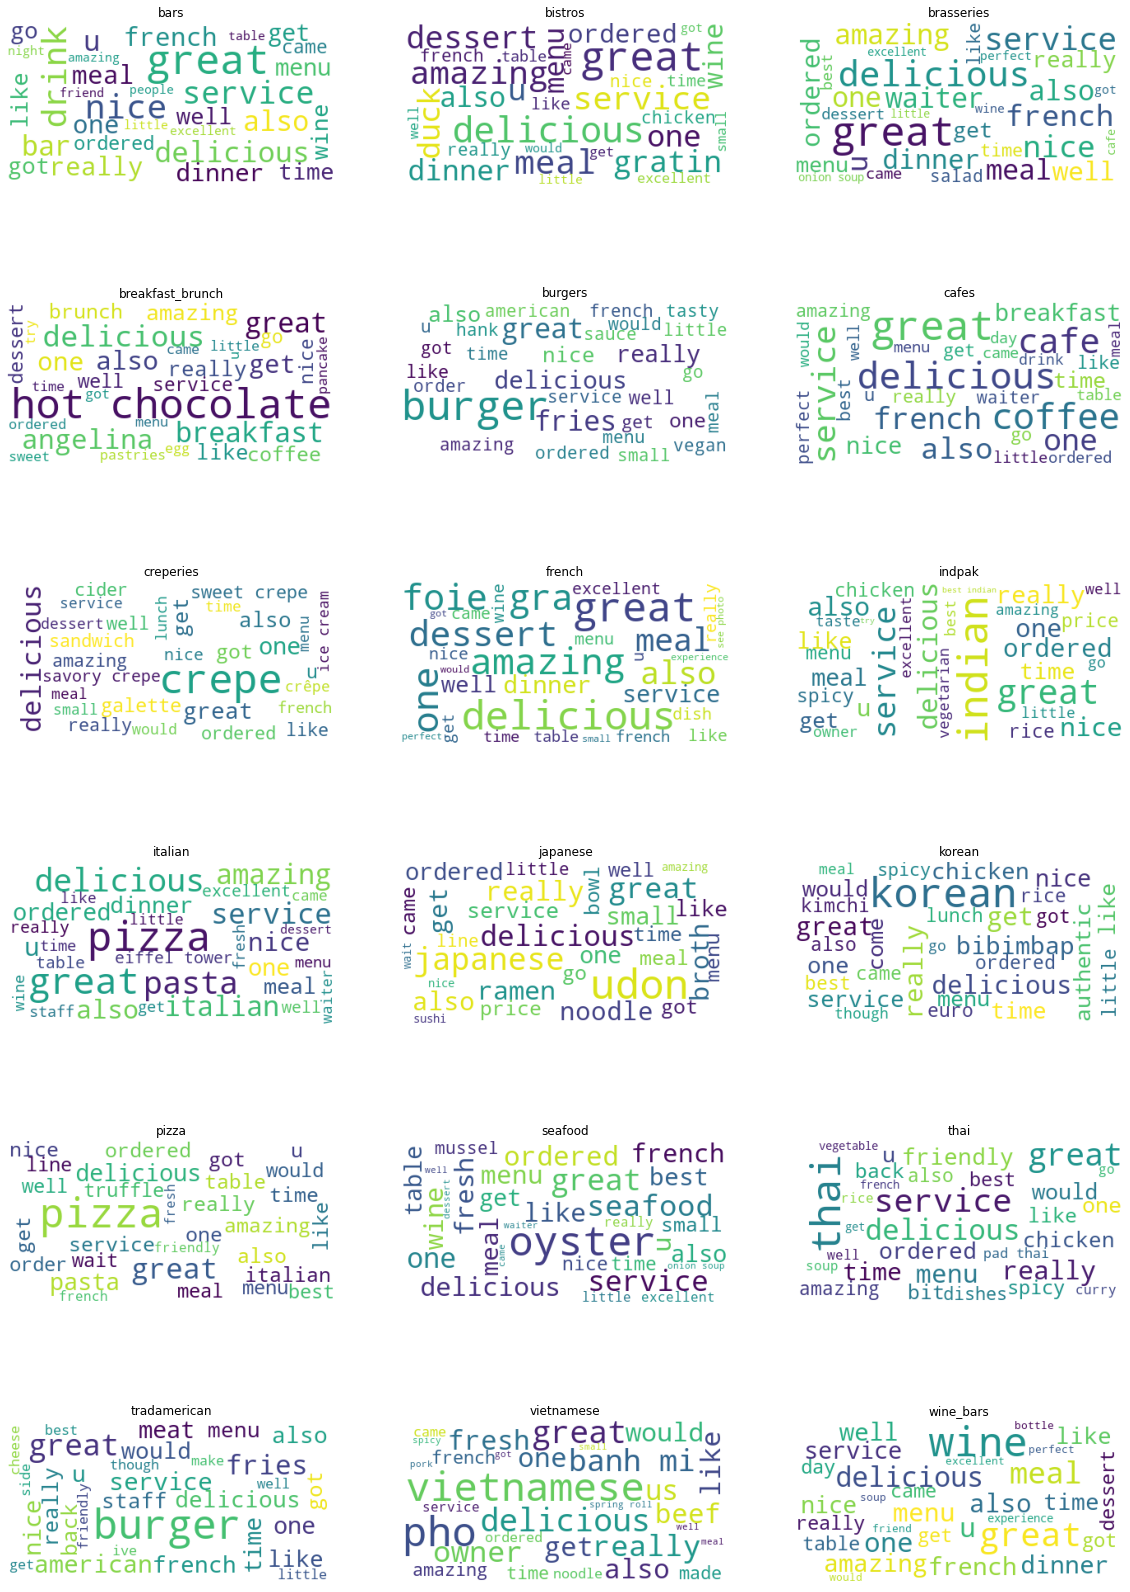

In [410]:
#create one wordcloud per category

fig , axs = plt.subplots(6,3,figsize=(20,30))

for i,c in enumerate(cat1_list):
    text=categories_reviews.loc[c,'review_clean']
    wordcloud_ = WordCloud(max_font_size=50, max_words=30,
                           background_color="white",stopwords=stopwords).generate(text)
    axs.flat[i].imshow(wordcloud_);
    axs.flat[i].axis('off',);
    axs.flat[i].set_title(c);